### This notebook shows you how to work with an MCS mask

In [96]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import binary_erosion
import colorcet as cc
%matplotlib inline

In [159]:
# Path to a single MCS track file
f = '/pscratch/sd/s/smheflin/uw_wrf/for_tracking_1.33km/mcstracking/20240817.0000_20240818.1300/mcstracks_20240818_020000.nc'

In [160]:
# Open dataset
ds = xr.open_dataset(f)
ds

<xarray.Dataset> Size: 51MB
Dimensions:                 (time: 1, lat: 924, lon: 663)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2024-08-18T02:00:00
    lat                     (lat, lon) float32 2MB ...
    lon                     (lat, lon) float32 2MB ...
Data variables: (12/13)
    base_time               (time) datetime64[ns] 8B ...
    longitude               (lat, lon) float32 2MB ...
    latitude                (lat, lon) float32 2MB ...
    REFL_10CM               (time, lat, lon) float32 2MB ...
    feature_number          (time, lat, lon) int64 5MB ...
    nfeatures               (time) int64 8B ...
    ...                      ...
    merge_tracknumber       (time, lat, lon) int64 5MB ...
    split_tracknumber       (time, lat, lon) int64 5MB ...
    track_status            (time, lat, lon) int64 5MB ...
    cloudtracknumber        (time, lat, lon) int64 5MB ...
    cloudmerge_tracknumber  (time, lat, lon) int64 5MB ...
    cloudsplit_tracknumber  (time, lat, lon) int64 5MB ...
Attributes:
    Title:         Pixel-level feature tracking data
    Institution:   Pacific Northwest National Laboratory
    Contact:       Zhe Feng: zhe.feng@pnnl.gov
    Created_on:    Wed Jan  8 15:09:52 2025
    min_size:      10.0
    field_thresh:  [  15 1000]

In [193]:
def make_dilation_structure(dilate_radius, dx, dy):
    """
    Make a circular dilation structure

    Args:z
        dilate_radius: float
            Dilation radius [kilometer].
        dx: float
            Grid spacing in x-direction [kilometer].
        dy: float
            Grid spacing in y-direction [kilometer]. 
    
    Returns:
        struc: np.array
            Dilation structure array.
    From Zhe Feng 
    """
    # Convert radius to number grids
    rad_gridx = int(dilate_radius / dx)
    rad_gridy = int(dilate_radius / dy)
    xgrd, ygrd = np.ogrid[-rad_gridx:rad_gridx+1, -rad_gridy:rad_gridy+1]
    # Make dilation structure
    strc = xgrd*xgrd + ygrd*ygrd <= (dilate_radius / dx) * (dilate_radius / dy)
    return strc


In [194]:
def label_perimeter(tracknumber, dilationstructure):
    """
    Labels the perimeter on a 2D map from object tracknumber masks.
    From Zhe Feng
    """
    # Get unique tracknumbers that is no nan
    tracknumber_unique = np.unique(tracknumber[~np.isnan(tracknumber)]).astype(np.int32)
    
    # Make an array to store the perimeter
    tracknumber_perim = np.zeros(tracknumber.shape, dtype=np.int32)

    # Loop over each tracknumbers
    for ii in tracknumber_unique:
        # Isolate the track mask
        itn = tracknumber == ii
        # Erode the mask by 1 pixel
        itn_erode = binary_erosion(itn, structure=dilationstructure).astype(itn.dtype)
        # Subtract the eroded area to get the perimeter
        iperim = np.logical_xor(itn, itn_erode)
        # Label the perimeter pixels with the track number
        tracknumber_perim[iperim == 1] = ii    
    return tracknumber_perim

In [195]:
perim_thick = 100 # adjust thickness of perimeter here 
pixel_radius = 25
dilationstructure = make_dilation_structure(perim_thick, pixel_radius, pixel_radius)
tracknumber_sub = ds['tracknumber'].squeeze()
tn_perim = label_perimeter(tracknumber_sub.data, dilationstructure)

### Plot track number 

In [216]:
tn_levels

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [225]:
from matplotlib.ticker import MaxNLocator


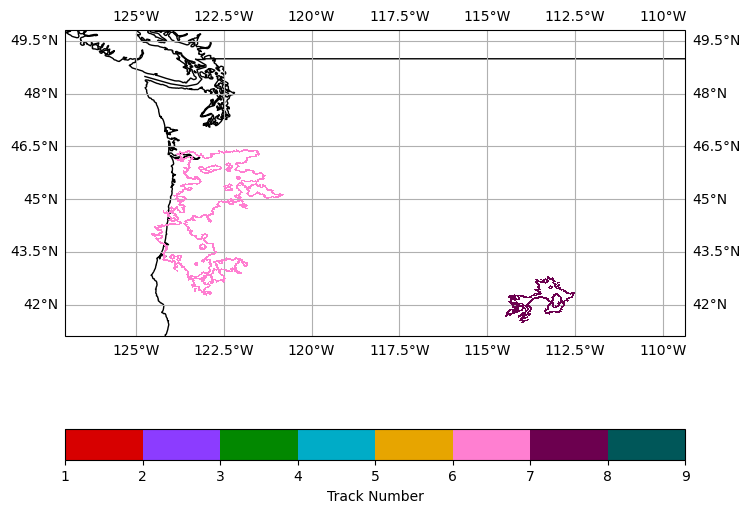

In [230]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Get fancy colorbar 
ax.gridlines(draw_labels = True)
tn_cmap = cc.cm["glasbey_dark"]
tn_nlev = 9
import matplotlib.colors as colors
tn_levels = np.linspace(np.min(0)+1, np.max(8)+1, tn_nlev)

norm = colors.BoundaryNorm(boundaries=tn_levels, ncolors = tn_nlev)

# Plot mask
#plt.pcolormesh(ds.lon, ds.lat, np.squeeze(ds.tracknumber))

# Plot outline 
Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
tn1 = ax.pcolormesh(ds.lon, ds.lat, Tn, cmap = tn_cmap,  norm = norm, zorder=4, alpha=1, )
cbar = plt.colorbar(tn1, ax = ax, orientation = 'horizontal', label = 'Track Number')